# Data analysis can be split into three elementary steps:
## 1. Importing the data
All the methods necessary to **read** the file contents, parse data and output it in desired format. Ie. something like that:
 
```
import pathlib
import pandas as pd

def data_import(self, path: pathlib.Path) -> pd.DataFrame:
    # ... 
    # dataframe =
    return dataframe
```

## 2. Processing the data
All the smoothing, normalization, interpolation, etc. should happen here. Implemented using composite design pattern.

## 3. Showing the data
ble ble

# Implementation using bridge design pattern/dependency injection:


In [1]:
import pathlib
from pathlib import Path
from IPython.display import display
from abc import ABC, abstractmethod
from typing import Callable, Optional, List
import pandas as pd
from pandas.errors import ParserError
import numpy as np
import itertools
import matplotlib.pyplot as plt
from lib.parser import *

absorbance_data =  Path('../patka-pomiary/CPE45_PFOBPy_comocat.txt')
fluorescence_data =  Path('../patka-pomiary/func39.txt')
corr_data = Path('../patka-pomiary/correction.csv')
corr = np.genfromtxt(corr_data, delimiter=',', dtype=float)


,correction,polyfit
0,,
1235.83,4809.46667,4894.049561
1239.01,4767.66667,4879.673126
1242.18,4726.26667,4867.565460
1245.35,4689.26667,4856.674599
1248.53,4672.13333,4846.056107
1251.70,NaN,4834.953880
1254.87,NaN,4822.602325
1258.04,NaN,4808.352646
1261.21,NaN,4791.638229


<AxesSubplot:xlabel='0'>

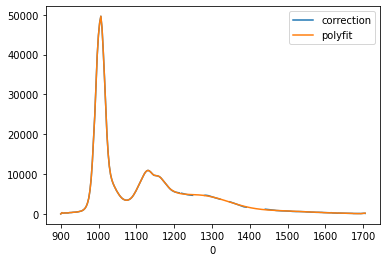

In [2]:
normalize = DataHandler(name='normalize', handler=lambda df: np.true_divide(df, df.where(np.logical_and(df.index>800, df.index<1000)).min()))
correction = DataHandler(name='correction', handler=lambda df: df.multiply(corr))
# filtering = DataHandler(fft_filter)

normalize2 = DataHandler(name='normalize2', handler=lambda df: df - df.where(np.logical_and(df.index>800, df.index<1000)).min()+1 )
correction2 = DataHandler(name='correction2', handler=lambda df: df[~np.isnan(corr)])
filtering2 = DataHandler(name='filtering2', handler=lambda df: df.replace(df.values, np.fft.irfft(np.array([e*(k<(df.size/6)) for k, e in enumerate(np.fft.rfft(df))]))))

def polyfit_handler(df, from_index = 1185):
    
    data4fit = df[from_index:]
    idx = np.isfinite(data4fit.index) & np.isfinite(data4fit.values)
    dm2_fit = np.polyval(np.polyfit(data4fit[idx].index, data4fit[idx].values, deg=9), data4fit.index)
    # data=[*df[:from_index].values, *dm2_fit]
    # plt.plot(data4fit.index, dm2_fit, marker = '.', ls='none', label='fullfit')
    # plt.show()
    # display(len(df[:from_index].values))
    # display(len(dm2_fit))
    # display(len(data))
    # display(pd.DataFrame( data=data ))

    return [*df[:from_index].values, *dm2_fit]

polyfit = DataHandler(name='polyfit', handler=polyfit_handler)

dm = DataModel(path=absorbance_data)
dm2 = DataModel(path=fluorescence_data)
# corr = DataMode(l(path=corr_data)


# fig, ax1 = plt.subplots()
# dm._pipeline.add(get_last_column_only)
# dm2._pipeline.add(get_last_column_only)

dm.add_to_pipeline(normalize2)
dm2.add_to_pipeline(correction, polyfit)

# plt.plot(data4fit.index, dm2_fit, marker = '.', ls='none', label='fullfit')
# dm2.data.plot(marker = '.', ls='none',label='polyfit')
# ax1.legend(frameon=False,ncol=3,fontsize=8,loc='upper right')
# plt.show()
# dm2_fit
# display(dm2.raw_data)
display(dm2.raw_data.iloc[105:120,4:7])
dm2.raw_data.iloc[:,4:7].plot()

,correction,polyfit
0,,
1235.83,4809.46667,4894.049561
1239.01,4767.66667,4879.673126
1242.18,4726.26667,4867.565460
1245.35,4689.26667,4856.674599
1248.53,4672.13333,4846.056107
1251.70,NaN,4834.953880
1254.87,NaN,4822.602325
1258.04,NaN,4808.352646
1261.21,NaN,4791.638229


<AxesSubplot:xlabel='0'>

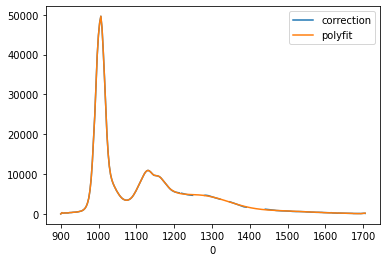

In [169]:

class Handler(ABC):
    @abstractmethod
    def handle(self, *args, **kwargs):
        raise NotImplementedError("You should implement this!")
        
    def update_handler(self, new_handler: Callable) -> None:
        self.handle = new_handler
        
class FileHandler(Handler):
    def handle(self, path: pathlib.Path) -> pd.DataFrame:
        with open(path) as f:
            for i, row in enumerate(f):
                for delimiter, decimal in (itertools.product([';',',','\t'], ['.',','])):
                    try:
                        df = pd.read_csv(path ,delimiter=delimiter, decimal=decimal, index_col=0, skiprows=i,header=None, on_bad_lines='skip', dtype=np.float64)
                        

                        return df
                        # return df[df.columns[-1]]

                    except Exception:
                        pass
    
class DataHandler(Handler):
    def __init__(self, name:Optional[str]='handler', handler: Optional[Callable]=None):
        self.name=name

        super().__init__()
        
        if handler is not None:
            self.update_handler(handler)
        
    def handle(self,  data: pd.DataFrame) -> pd.DataFrame:
        return data

class Pipeline(DataHandler):
    def __init__(self) -> None:
        self.operations: List[DataHandler] = []
        
    def handle(self,  df: pd.DataFrame) -> pd.DataFrame:
        for o in self.operations:
            data = df[df.columns[-1]]
            df[o.name]= o.handle( data )
        return df

    def add(self, *operations: DataHandler) -> None:
        for o in operations:
            self.operations.append(o)

    def remove(self,*operations: DataHandler) -> None:
        for o in operations:
            self.operations.remove(o)
            
class DataModel(ABC):
    def __init__(self, path: pathlib.Path, reader: Optional[FileHandler]=FileHandler(), pipeline: Optional[Pipeline]=None ) -> None:
        self._path=path
        self._reader=reader

        self._pipeline=pipeline if pipeline is not None else Pipeline()

        self.update()

    def update(self):
        self.raw_data = self._reader.handle(self.path)
        self.all_data = self._pipeline.handle(self.raw_data)
        self.data = self.all_data[self.all_data.columns[-1]]

    def add_to_pipeline(self, *operations: DataHandler):
        self._pipeline.add(*operations)
        self.update()
    @property
    def path(self):
        return self._path
    
    @path.setter
    def path(self, path: pathlib.Path):
        self._path = path
        self.update()
# get_last_column_only = DataHandler(lambda df: df[df.columns[-1]])
normalize = DataHandler(name='normalize', handler=lambda df: np.true_divide(df, df.where(np.logical_and(df.index>800, df.index<1000)).min()))
correction = DataHandler(name='correction', handler=lambda df: df.multiply(corr))
# filtering = DataHandler(fft_filter)

normalize2 = DataHandler(name='normalize2', handler=lambda df: df - df.where(np.logical_and(df.index>800, df.index<1000)).min()+1 )
correction2 = DataHandler(name='correction2', handler=lambda df: df[~np.isnan(corr)])
filtering2 = DataHandler(name='filtering2', handler=lambda df: df.replace(df.values, np.fft.irfft(np.array([e*(k<(df.size/6)) for k, e in enumerate(np.fft.rfft(df))]))))

def polyfit_handler(df, from_index = 1185):
    
    data4fit = df[from_index:]
    idx = np.isfinite(data4fit.index) & np.isfinite(data4fit.values)
    dm2_fit = np.polyval(np.polyfit(data4fit[idx].index, data4fit[idx].values, deg=9), data4fit.index)
    # data=[*df[:from_index].values, *dm2_fit]
    # plt.plot(data4fit.index, dm2_fit, marker = '.', ls='none', label='fullfit')
    # plt.show()
    # display(len(df[:from_index].values))
    # display(len(dm2_fit))
    # display(len(data))
    # display(pd.DataFrame( data=data ))

    return [*df[:from_index].values, *dm2_fit]

polyfit = DataHandler(name='polyfit', handler=polyfit_handler)

dm = DataModel(path=absorbance_data)
dm2 = DataModel(path=fluorescence_data)
# corr = DataMode(l(path=corr_data)


# fig, ax1 = plt.subplots()
# dm._pipeline.add(get_last_column_only)
# dm2._pipeline.add(get_last_column_only)

dm.add_to_pipeline(normalize2)
dm2.add_to_pipeline(correction, polyfit)

# plt.plot(data4fit.index, dm2_fit, marker = '.', ls='none', label='fullfit')
# dm2.data.plot(marker = '.', ls='none',label='polyfit')
# ax1.legend(frameon=False,ncol=3,fontsize=8,loc='upper right')
# plt.show()
# dm2_fit
# display(dm2.raw_data)
display(dm2.raw_data.iloc[105:120,4:7])
dm2.raw_data.iloc[:,4:7].plot()


In [161]:
from ipywidgets import SelectMultiple, GridBox, Layout,VBox, Label, interactive_output, Output, ToggleButton

path=Path('../patka-pomiary/Funkcjonalizacja_nanorurek-test.csv')
df = pd.read_csv(path, index_col=1).fillna('')

class modulePanel(VBox):
    def __init__(self, label, options, *args, **kwargs):
        self.label = label
        self.select = SelectMultiple( options=options, layout=Layout(height='100px', width='100%') )

        self.toggle = ToggleButton( description=label)
        self.update = None
        def select_handler(value):
            if (len(self.select.value) >0):
                self.toggle.disabled=True
            else:
                self.toggle.disabled=False
            if self.update is not None:
                self.update()

        def toggle_handler(value):
            if (self.toggle.value) :
                self.children=[self.toggle, self.select]  
            else:
                self.children=[self.toggle]
                
        self.select.observe(select_handler, 'value') 

        self.toggle.observe(toggle_handler, 'value') 
        
        super().__init__([self.toggle], *args, **kwargs)
        self.layout.overflow = 'hidden'
    @property
    def value(self):
        return {self.label : self.select.value}
    
class controlPanel(VBox):
    def __init__(self, *args, **kwargs):
        self.modules = [modulePanel(label=str(column), options=df[column].unique()) for column in df.columns]
        self.output = Output()
        super().__init__([GridBox(self.modules, layout=Layout(grid_template_columns="repeat(10, 10%)")),
                          self.output], *args, **kwargs)
        for module in self.modules:
            module.update = self.update
    def update(self):
        print([df[key].isin(list(value)) for (key,value) in self.value.items()])
    @property
    def value(self):
        v={}
        for c in self.modules:
            key, value = list(c.value.keys())[0], list(c.value.values())[0]
            if ( len(value)>0 ):
                v[key]=value
        return v
    
items = [VBox([Label(str(column)), SelectMultiple(options=df[column].unique(), layout=Layout(height='100px', width='80%', overflow='hidden hidden'), )]) for column in df.columns]

gb=controlPanel()
gb

controlPanel(children=(GridBox(children=(modulePanel(children=(ToggleButton(value=False, description='Typ'),),…

In [162]:
import pandas as pd

pd.show_versions()


INSTALLED VERSIONS
------------------
commit           : 5f648bf1706dd75a9ca0d29f26eadfbb595fe52b
python           : 3.9.7.final.0
python-bits      : 64
OS               : Windows
OS-release       : 10
Version          : 10.0.19042
machine          : AMD64
processor        : AMD64 Family 23 Model 24 Stepping 1, AuthenticAMD
byteorder        : little
LC_ALL           : None
LANG             : None
LOCALE           : English_Europe.1252

pandas           : 1.3.2
numpy            : 1.21.2
pytz             : 2021.1
dateutil         : 2.8.2
pip              : 22.0.3
setuptools       : 57.4.0
Cython           : None
pytest           : None
hypothesis       : None
sphinx           : None
blosc            : None
feather          : None
xlsxwriter       : None
lxml.etree       : 4.6.4
html5lib         : None
pymysql          : None
psycopg2         : None
jinja2           : 3.0.1
IPython          : 7.27.0
pandas_datareader: None
bs4              : 4.9.3
bottleneck       : None
fsspec          